In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.utils.data import random_split

from urllib.request import urlretrieve
import json

import matplotlib.pyplot as plt
import PIL

2023-12-22 07:51:49.845709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 07:51:49.939837: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


- training details
- randomly sample 224×224 crops for data augmentation.
- We use a mini-batch size of 256 images for fine-tuning
- The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 10^4 iterations.
- We use a weight decay of 0.0001 and a momentum of 0.9. We do not use dropout
- We initialize the learning rate for the pre-trained network to be 0.01

# Load ImageNet

In [34]:
# make trainset using /home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train 
trainset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train', 
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

# make valset using /home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val 
valset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val', 
    transform = transforms.Compose([
         transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [35]:
mini_batch_size = 256
# make trainloader
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=mini_batch_size, shuffle=True, num_workers=4
)

# make valloader
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=mini_batch_size, shuffle=True, num_workers=4
)

In [36]:
# mini_batch_size = 256
print(f"mini_batch_size : {mini_batch_size}")

# check the size of trainset and valset
print(f"len(trainset) : {len(trainset)}") # the number of train images = 1,281,167
print(f"len(valset) : {len(valset)}")     # the number of val images   =    50,000

# check the size of train_loader and val_loader
print(f"len(train_loader) : {len(train_loader)}")  # the number of train batches = 5,005 (1,281,167 / mini_batch_size)
print(f"len(val_loader) : {len(val_loader)}")      # the number of val batches   =   196 (   50,000 / mini_batch_size)

mini_batch_size : 256
len(trainset) : 1281167
len(valset) : 50000
len(train_loader) : 5005
len(val_loader) : 196


In [37]:
num_train_examples = len(trainset)
num_val_examples = len(valset)
num_train_batch = len(train_loader) # the number of train batches = 5,005 (1,281,167 / mini_batch_size)
num_val_batch = len(val_loader)     # the number of val batches   =   196 (   50,000 / mini_batch_size)

print(f"# train examples : {num_train_examples}")
print(f"# val examples : {num_val_examples}")
print(f"# train batches : {num_train_batch}")
print(f"# val batches : {num_val_batch}")

# train examples : 1281167
# val examples : 50000
# train batches : 5005
# val batches : 196


In [38]:
# check the structure of train_loader
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([256, 3, 224, 224])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

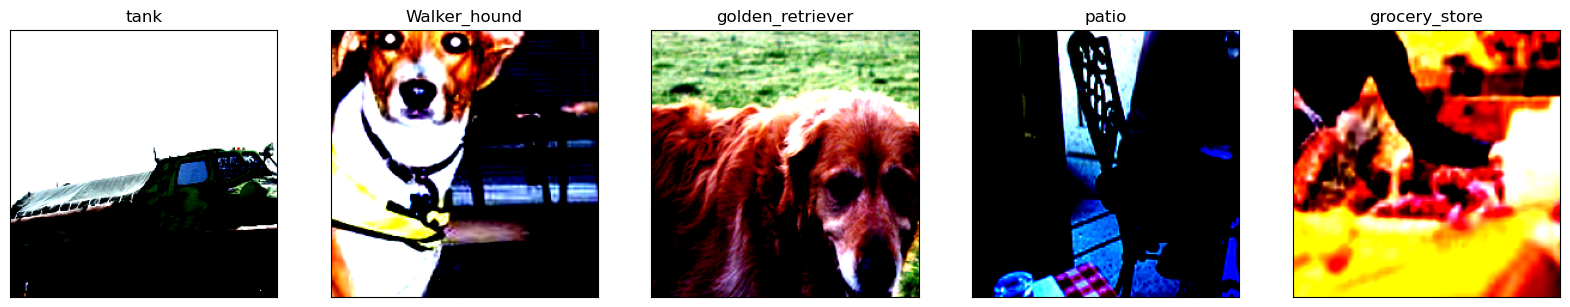

In [39]:
import random
import json

# 1000 classes
num_classes = 1000
with open('/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/imagenet_class_index.json') as f:
    class_index = json.load(f)
# Get the human-readable class names
class_names = [class_index[str(i)][1] for i in range(num_classes)]
# Print the class names
print(class_names)

writer = SummaryWriter('runs/my_resnet34_imagenet_experiment_1')
# check random 5 examples of trainset
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(torch.randint(len(trainset), size=(5,))):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    image, label = trainset[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(class_names[label])
    

# modeling ResNet34 by myself

* paper_resnet34 architecture : 
   - 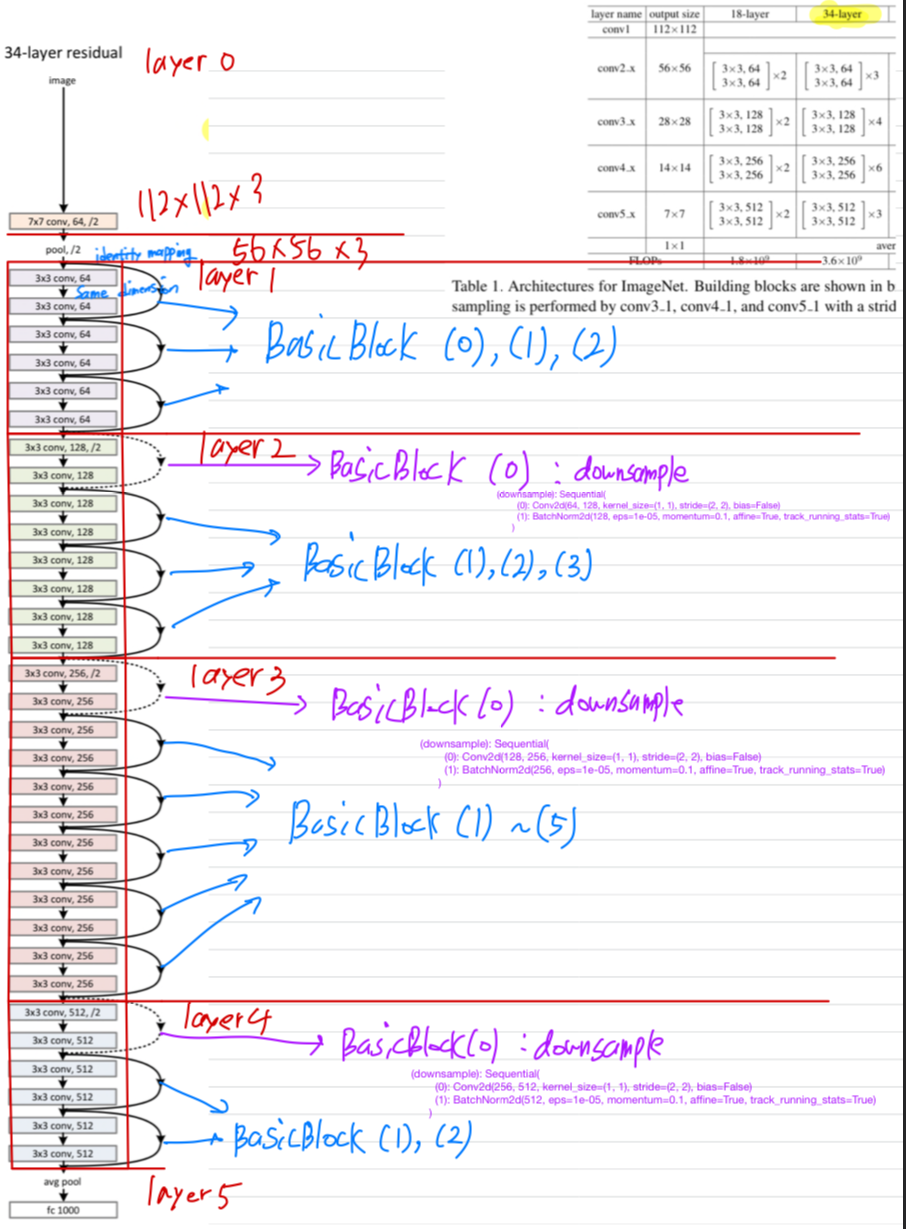
   - 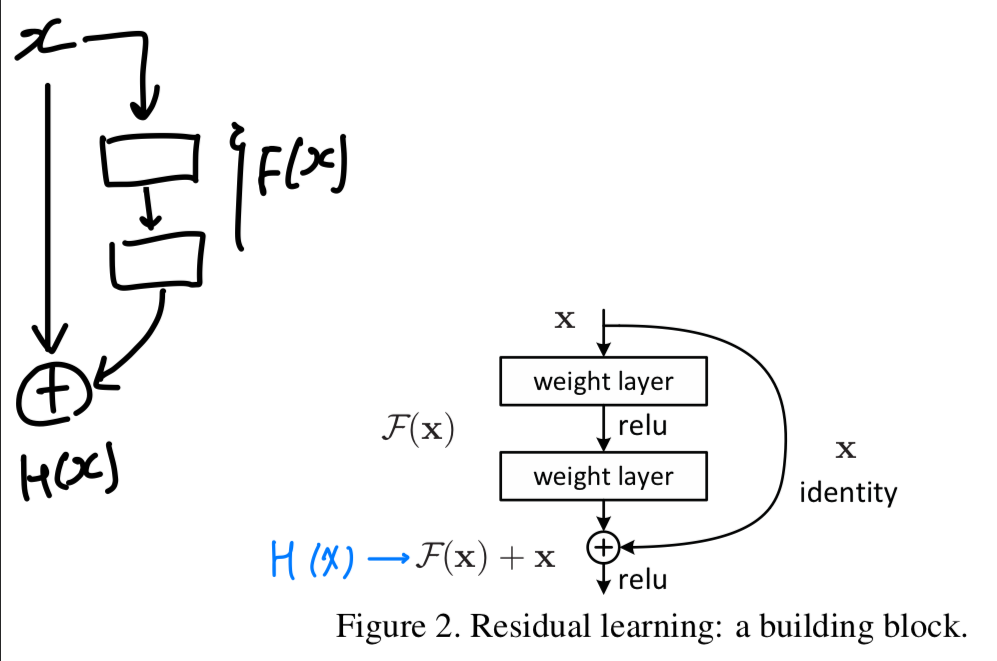


In [40]:
class BuildingBlock(nn.Module) :
    def __init__(self, in_channels, out_channels) :
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = 1      # In block without down_sampling, stride is 1.
        self.kernel_size = 3 # In block without down_sampling, kernel_size is 3.
        self.padding = 1
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=True)
    
    def forward(self, x) : 
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity # identity mapping
        out = self.relu2(out)
        
        return out

In [41]:
class BuildingBlockWithDownSample(nn.Module) :
    def __init__(self, in_channels, out_channels) :
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = 3
        self.down_sampling_kernel_size = 1
        self.conv1_stride = 2 # In block with down_sampling, conv1's stride is 2.
        self.conv2_stride = 1 # In block with down_sampling, conv2's stride is 1.
        self.padding = 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.conv1_stride, padding=self.padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, stride=self.conv2_stride, padding=self.padding, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.down_sampling_kernel_size, stride=self.conv1_stride, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        )
    
    def forward(self, x) : 
        identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity       # identity mapping
        out = self.relu2(out) # block output
        
        return out
        
        

In [42]:
# Class ResNet34 > Class BuildingBlock, Class BuildingBlockWithDownSample
class MyResNet34(nn.Module) :
    def __init__(self) :
        super().__init__()
        num_classes : int = 1000
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), # affine : True ? gamma, beta, track_running_stats : True ? running_mean, running_var
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.layer1 = nn.Sequential(
            BuildingBlock(64, 64),
            BuildingBlock(64, 64),
            BuildingBlock(64, 64),
        )
        self.layer2 = nn.Sequential(
            BuildingBlockWithDownSample(64, 128),
            BuildingBlock(128, 128),
            BuildingBlock(128, 128),
            BuildingBlock(128, 128),
        )
        self.layer3 = nn.Sequential(
            BuildingBlockWithDownSample(128, 256),
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
        )
        self.layer4 = nn.Sequential(
            BuildingBlockWithDownSample(256, 512),
            BuildingBlock(512, 512),
            BuildingBlock(512, 512),
        )
        self.layer5 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes, bias=True),
        )
        
    def forward(self, x) : 
        ## Input size : 224 x 224 x 3 -> 112 x 112 x 64 -> Output size : 56 x 56 x 64
        x = self.layer0(x)
        ## Input size : 56 x 56 x 64, Output size : 56 x 56 x 64
        x = self.layer1(x)
        ## Input size : 56 x 56 x 64, Output size : 28 x 28 x 128
        x = self.layer2(x)
        ## Input size : 28 x 28 x 128, Output size : 7 x 7 x 512
        x = self.layer3(x)
        ## Input size : 7 x 7 x 512, Output size : 1 x 1 x 512
        x = self.layer4(x)
        ## Input size : (mini_batch_size) x 1 x 1 x 512 ->  1 x 1 x 512 -> Output size : 1 x 1 x 1000
        x = self.layer5(x)
        
        return x        
        

In [43]:
# training details
## randomly sample 224×224 crops for data augmentation.
## We use a mini-batch size of 256 images for fine-tuning
## The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 10^4 iterations.
## We use a weight decay of 0.0001 and a momentum of 0.9. We do not use dropout
## We initialize the learning rate for the pre-trained network to be 0.01
model = MyResNet34()
print(model.eval)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

<bound method Module.eval of MyResNet34(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=

In [44]:
# hyper parameters
## learning rate
lr = 0.01
## momentum
momentum = 0.9
## weight decay
L2 = 0.0001
# the number of iterations at 1 epoch
num_iters = (len(trainset) // mini_batch_size) + 1
# the number of epochs
epochs = 120
print(f"num_iters at 1 epoch: {num_iters}")
total_num_iters = num_iters * epochs
print(f"total num_iters: {total_num_iters}")

## optimizer
## scheduler
## loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

## if val loss plateaus, lr decay
lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

num_iters at 1 epoch: 5005
total num_iters: 600600


In [45]:
# record model to tensorboard
# Assuming 'device' is defined as torch.device("cuda") or "cuda:0"
input_tensor = trainset[0][0].unsqueeze(0).to(device)
writer.add_graph(model, input_tensor)

In [46]:
# for visualization, record training loss and val loss
train_loss_list = []
val_loss_list = []

# accuracy
val_acc_list = []

In [ ]:
# import time
# # Start measuring time
# start_time = time.time()

# # ------------------------------------------------------------------------------------------------------------------------------

# # training no pretrained resnet34 model with GPU
# model.train().to(device)
# for epoch in range(epochs):
#     running_loss = 0.0
#     print(f"{epoch+1} / {epochs} epoch ----------------------------------------")
#     for i, data in enumerate(train_loader):
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)
        
#         # zero the parameter gradients
#         optimizer.zero_grad()
        
#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         # every 1,000 iteration
#         running_loss += loss.item()
#         if i % 1000 == 999:
#             print(f"[{epoch+1}, {i+1}th iteration] loss : {running_loss / 1000}")
#             writer.add_scalar('training loss', running_loss / 1000, epoch * num_iters + i)
#             running_loss = 0.0
            
#     # every epoch
#     # validation loss, accuracy
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in val_loader:
#             images, labels = data
#             images = images.to(device)
#             labels = labels.to(device)
            
#             outputs = model(images)
#             loss = criterion(outputs, labels)
            
#             val_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()
#     print(f"val loss : {val_loss / num_val_batch}")
#     print(f"val acc : {100. * correct / total}")
#     writer.add_scalar('validation loss', val_loss / num_val_batch, epoch)
#     writer.add_scalar('validation acc', 100. * correct / total, epoch)
#     writer.flush()
#     lr_scheduler.step(val_loss / num_val_batch)
#     val_loss_list.append(val_loss / num_val_batch)
#     val_acc_list.append(100. * correct / total)
            
    
#     # checkpoint
#     PATH = f"./Paper_ResNet34_ImageNet_Checkpoint/epoch_{epoch}.pth"
#     torch.save(model.state_dict(), PATH)
#     # save best model (minimum val loss)
#     if val_loss / num_val_batch == min(val_loss_list):
#         PATH = f"./Paper_ResNet34_ImageNet_Checkpoint/best_model.pth"
#         torch.save(model.state_dict(), PATH)
    
    
# # ------------------------------------------------------------------------------------------------------------------------------        
        
# # End measuring time
# end_time = time.time()

# # Calculate and print the training time
# training_time = end_time - start_time
# print(f"Training time: {training_time:.2f} seconds")

In [ ]:
# # visualize train_loss_list, val_loss_list, val_acc_list
# plt.figure(figsize=(20, 12))
# plt.plot(train_loss_list, label='train loss')
# plt.plot(val_loss_list, label='val loss')
# plt.plot(val_acc_list, label='val acc')
# plt.legend()
# plt.show()